In [464]:
using Distributions
using Plots
using Plots.PlotMeasures
using DelimitedFiles

function generate_classes(n_samples, n_points, alpha, noise_strength)
    x_min = 0
    x_max = 2π
    dx = (x_max - x_min) / (n_points)
    x = range(x_min, stop=x_max - dx, length=n_points)

    class_A = Matrix{Float64}(undef, n_samples, n_points)
    class_B = Matrix{Float64}(undef, n_samples, n_points)
    class_A_label = []
    class_B_label = []

    for i in 1:n_samples
        curve_A = []
        curve_B = []
        mu = sin.(x)  # Calculate mu for each x using the sine function

        for j in 1:length(mu)-1
            y_A = rand(Normal(mu[j], 1))  # Generate class A data
            #y_A = rand(Normal(mu[j], 1))
            y_B = rand(Normal(mu[j], 1))  # Generate class B data
            #y_B = rand(Normal(mu[j], 1))
            push!(curve_A, y_A)
            push!(curve_B, y_B)
        end
        
        # Handle the last point with specific dependency on the first point
        mu_last = mu[end]
        y_A_last = alpha * curve_A[1] + noise_strength*rand(Normal(mu_last, 1))
        y_B_last = -alpha * curve_B[1] + noise_strength*rand(Normal(mu_last, 1))
        push!(curve_A, y_A_last)
        push!(curve_B, y_B_last)

        class_A[i, :] = curve_A
        class_B[i, :] = curve_B
        push!(class_A_label, 0)
        push!(class_B_label, 1)
    end
    y_int = sin(x[end])
    return class_A, class_B, class_A_label, class_B_label, x, y_int
end


# function plot_distributions_grid(class_A, n_points, rows, cols, x_values, alpha)
#     # Create a plot with subplots arranged in a grid of `rows` x `cols`
#     p = plot(layout=(rows, cols), size=(1500, 1500), left_margin = 5mm)  # Adjust size as needed
#     for j in 1:n_points
#         column_values = class_A[:, j]
#         x = x_values[j]
#         mu = sin(x)
#         #@show mu
#         # Each subplot represents the distribution at one point, histogram entry in legend is turned off
#         histogram!(p, column_values, normalize=true, subplot=j, title="Distribution of Point $j",
#                    xlabel="Value", ylabel="Density", legend=true, label = "")
#         # Plot the normal distribution curve and use legend to indicate mean
#         if j == n_points
#             sigma = sqrt(alpha^2+1)
#             mu = sin(x_values[n_points])
#             plot!(p, x -> pdf(Normal(0, sigma), x), lw=2, c=:red, label="μ=0.0, σ=$(round(sigma, digits=2))", loc=:best, subplot=j)
#         else
#             plot!(p, x -> pdf(Normal(mu, 1), x), lw=2, c=:red, label="μ=$(round(mu, digits=2)), σ=1", loc=:best, subplot=j)
#         end
#     end
    
#     display(p)
#     return p
# end

function plot_distributions_grid(class_A, n_points, rows, cols, x_values, alpha, noise_strength)
    p = plot(layout=(rows, cols), size=(1500, 1500), left_margin = 5mm)
    
    for j in 1:n_points
        column_values = class_A[:, j]
        x = x_values[j]

        if j == n_points
            sigma = noise_strength * sqrt(alpha^2+1)
            mu = sin(x)*(noise_strength + 1) # Explicitly setting mean to zero for the last point
        else
            sigma = noise_strength  # Standard deviation for other points
            mu = sin(x)*(noise_strength + 1)
        end

        # Plot histogram
        histogram!(p, column_values, normalize=true, subplot=j,
                   title="Distribution of Point $j", xlabel="Value", ylabel="Density", legend=:best, label = "")

        # Calculate plot range for the curve
        xmin, xmax = extrema(column_values)  # Get the range of the histogram data
        x_range = range(xmin - 1 * sigma, xmax + 1 * sigma, length=300)  # Extend range to cover tails
        
        # Plot normal distribution curve
        normal_curve = pdf.(Normal(mu, sigma), x_range)
        plot!(p, x_range, normal_curve, lw=2, c=:red, label="μ=$(round(mu, digits=2)), σ=$(round(sigma, digits=2))", subplot=j)
    end

    #display(p)
    return p
end


# class_A, class_B, class_A_label, class_B_label, x, y_int = generate_classes(500, 20, 2, 0.1)
# myfig = plot_distributions_grid(class_B, 20, 5, 4, x, 2, 0.1)

# writedlm("guassian_curves_500_20_2_class_A.csv", class_A, ",")
# writedlm("guassian_curves_500_20_2_class_A_labels.csv", class_A_label, ",")
# writedlm("guassian_curves_500_20_2_class_B.csv", class_B, ",")
# writedlm("guassian_curves_500_20_2_class_B_labels.csv", class_B_label, ",")
#savefig(myfig, "distributions_alpha=2.png")

# Function to create scatter plot

function scatter_plot_classes(class_A, class_B, alpha, y_int, noise_strength)
    # Extract the first and last points from class_A
    first_points_A = class_A[:, 1]
    last_points_A = class_A[:, end]
    
    # Extract the first and last points from class_B
    first_points_B = class_B[:, 1]
    last_points_B = class_B[:, end]
    
    # Determine the limits for the plot
    x_all = [first_points_A; first_points_B]
    y_all = [last_points_A; last_points_B]
    x_min, x_max = extrema(x_all)
    y_min, y_max = extrema(y_all)
    
    # Create scatter plot with transparency
    scatter(first_points_A, last_points_A, label="Class A", color=:blue, xlabel="\$X_{1}\$", ylabel="\$X_{N}\$", 
            legend=:right, alpha=2)
    scatter!(first_points_B, last_points_B, label="Class B", color=:red, alpha=2)
    
    # Add the line y = alpha * x
    y_1 = alpha*first_points_A .+ noise_strength*y_int
    y_2 = -alpha*first_points_B .+ noise_strength*y_int
    plot!(first_points_A, y_1, color=:black, lw = 4, label = "\$y=\\alpha x\$")
    plot!(first_points_B, y_2, color=:black, lw = 4, label = "\$y=-\\alpha x\$")
    # plot!([x_min, x_max], [alpha*x_min + y_int, alpha*x_max + y_int], label="\$y = \\alpha x+C\\eta\$", color=:black, lw=2)
    # plot!([x_min, x_max], [-alpha*x_min + y_int, -alpha*x_max + y_int], label="\$y = -\\alpha x+C\\eta\$", color=:black, lw=2)

    # Adjust the plot to fill the space
    xlims!(x_min, x_max)
    ylims!(y_min, y_max)
    title!("Scatterplot Between \$X_{1}\$ and \$X_{N}\$ Demonstrating \n Positive and Negative Autocorrelation")
    

    # Display the plot
    display(current())
    savefig("scatterplot_500_20_1_0.1_talk.png")
    savefig("scatterplot_500_20_1_0.1_talk.pdf")
    #return first_points_A
end



#scatter_plot_classes(class_A, class_B, 2)
# Example usage with generated data (ensure you have class_A and class_B available):
# Generate the classes (assumes you already have this function defined)
# class_A, class_B, class_A_label, class_B_label = generate_classes(50, 20, 0.8)

# Create the scatter plot
# scatter_plot_classes(class_A, class_B, 0.8)



scatter_plot_classes (generic function with 1 method)

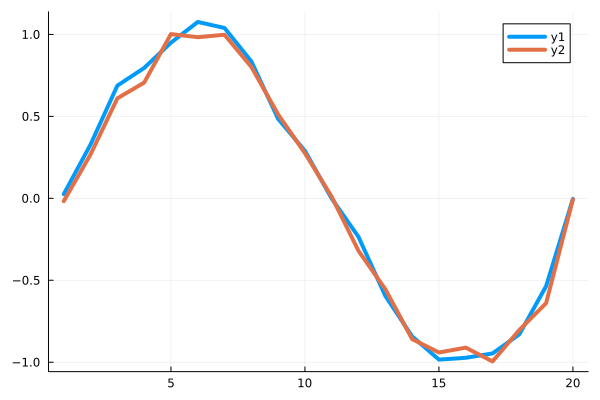

In [456]:
n_samples = 500
n_points = 20
alpha = 1
noise_strength = 0.1
rows = 5
cols = 2



class_A, class_B, class_A_label, class_B_label, x_values, y_int = generate_classes(n_samples, n_points, alpha, noise_strength)

# writedlm("guassian_curves_500_10_1_0.1_class_A.csv", class_A, ",")
# writedlm("guassian_curves_500_10_1_0.1_class_A_labels.csv", class_A_label, ",")
# writedlm("guassian_curves_500_10_1_0.1_class_B.csv", class_B, ",")
# writedlm("guassian_curves_500_10_1_0.1_class_B_labels.csv", class_B_label, ",")

#myfig = plot_distributions_grid(class_B, n_points, rows, cols, x_values, alpha, noise_strength)
# savefig(myfig, "distributions_500_10_1_0.1.png")
# savefig(myfig, "distributions_500_10_1_0.1.pdf")

# means = mean(class_A, dims = 1)
# stds = std(class_A, dims = 1)
#hey = scatter_plot_classes(class_A, class_B, alpha, y_int, noise_strength)
#extrema(hey)
# writedlm("guassian_curves_500_20_1_0_class_A.csv", class_A, ",")
# writedlm("guassian_curves_500_20_1_0_class_A_labels.csv", class_A_label, ",")
# writedlm("guassian_curves_500_20_1_0_class_B.csv", class_B, ",")
# writedlm("guassian_curves_500_20_1_0_class_B_labels.csv", class_B_label, ",")

# means = mean(class_A, dims = 1)
# means_2 = mean(class_B, dims = 1)
# means = vec(means)
# means_2 = vec(means_2)
# plot(means)
# plot!(means_2)

plot(class_A[1, :])
plot!(class_B[1, :])

means_A = mean(class_A, dims = 1)
means_B = mean(class_B, dims = 1)
plot(vec(means_A), lw = 4)
plot!(vec(means_B), lw = 4)

In [439]:
# folder = "Plots"
# savefig(joinpath(folder, "distributions_500_20_1_0.1.pdf"))

folder = "datasets"
full_path = joinpath(folder, "guassian_curves_500_10_1_0.1_class_A.csv")
full_path_2 = joinpath(folder, "guassian_curves_500_10_1_0.1_class_A_labels.csv")
full_path_3 = joinpath(folder, "guassian_curves_500_10_1_0.1_class_B.csv")
full_path_4 = joinpath(folder, "guassian_curves_500_10_1_0.1_class_B_labels.csv")

writedlm(full_path, class_A, ',')
writedlm(full_path_2, class_A_label, ',')
writedlm(full_path_3, class_B, ',')
writedlm(full_path_4, class_B_label, ',')


In [391]:
for i = 1:10
    if i % 4 == 1 || i % 4 == 2
        println("hey")
    else
        println("heyx")
    end
end

hey
hey
heyx
heyx
hey
hey
heyx
heyx
hey
hey


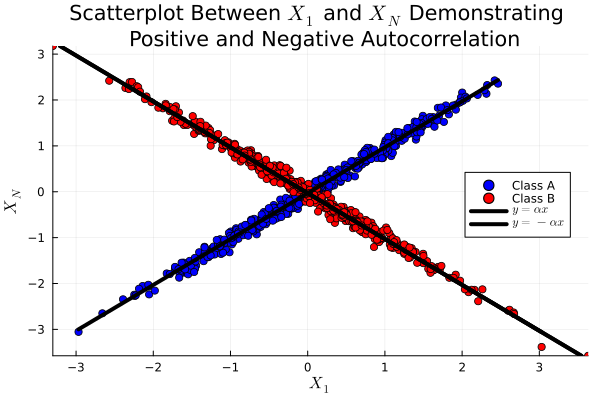

"/Users/angusrutherford/Desktop/Honours/Project/Code/QuantumInspiredML/LogLoss/scatterplot_500_20_1_0.1_talk.pdf"

In [465]:
scatter_plot_classes(class_A, class_B, alpha, y_int, noise_strength)

In [315]:
train_OBC = readdlm("/Users/angusrutherford/Desktop/Honours/Project/Code/QuantumInspiredML/LogLoss/Data/train_fourier_chi_2_eta_0.05_matrix.csv", ',')
test_OBC = readdlm("/Users/angusrutherford/Desktop/Honours/Project/Code/QuantumInspiredML/LogLoss/Data/test_fourier_chi_2_eta_0.05_matrix.csv", ',')
train_PBC = readdlm("/Users/angusrutherford/Desktop/Honours/Project/Code/QuantumInspiredML/LogLoss/Data/train_fourier_chi_2_eta_0.05_sweeps_40_PBC_both.csv", ',')
test_PBC = readdlm("/Users/angusrutherford/Desktop/Honours/Project/Code/QuantumInspiredML/LogLoss/Data/test_fourier_chi_2_eta_0.05_sweeps_40_PBC_both.csv", ',')

mean_train_OBC = mean(train_OBC, dims = 1)
mean_train_OBC = vec(mean_train_OBC)
pushfirst!(mean_train_OBC, mean_train_OBC[end])

mean_test_OBC = mean(test_OBC, dims = 1)
mean_test_OBC = vec(mean_test_OBC)
pushfirst!(mean_test_OBC, mean_test_OBC[end])

mean_train_PBC = mean(train_PBC, dims = 1)
mean_train_PBC = vec(mean_train_PBC)
pushfirst!(mean_train_PBC, mean_train_PBC[end])

mean_test_PBC = mean(test_PBC, dims = 1)
mean_test_PBC = vec(mean_test_PBC)
pushfirst!(mean_test_PBC, mean_test_PBC[end])

std_train_OBC = std(train_OBC, dims = 1)
std_train_OBC = vec(std_train_OBC)
pushfirst!(std_train_OBC, std_train_OBC[end])

std_test_OBC = std(test_OBC, dims = 1)
std_test_OBC = vec(std_test_OBC)
pushfirst!(std_test_OBC, std_test_OBC[end])

std_train_PBC = std(train_PBC, dims = 1)
std_train_PBC = vec(std_train_PBC)
pushfirst!(std_train_PBC, std_train_PBC[end])

std_test_PBC = std(test_PBC, dims = 1)
std_test_PBC = vec(std_test_PBC)
pushfirst!(std_test_PBC, std_test_PBC[end])

x = range(-pi, stop = pi, length = 21)
x_tick_vals = range(-pi, stop = pi, length = 5)
x_tick_labels = ["-π", "-π/2", "0", "π/2", "π"]

plot(x, mean_train_OBC, ribbon = std_train_OBC, xticks = (x_tick_vals, x_tick_labels), linewidth = 4, label = "Mean Training Accuracy (OBC) ± 1 SD")
plot!(x, mean_test_OBC, ribbon = std_test_OBC, linewidth = 4, label = "Mean Testing Accuracy (OBC) ± 1 SD")
plot!(x, mean_train_PBC, ribbon = std_train_PBC, linewidth = 4, label = "Mean Training Accuracy (PBC) ± 1 SD")
plot!(x, mean_test_PBC, ribbon = std_test_PBC, linewidth = 4, label = "Mean Testing Accuracy (PBC) ± 1 SD")
xlabel!("Phase (radians)")
ylabel!("Accuracy")
title!("Comparison of Training and Testing Accuracies for OBC and PBC on \n Synthetic Dataset \$\\chi_{max}=2\$, \$\\eta=0.05\$, Fourier, 20 MPS Initialisations", titlefontsize=11)
savefig("comparison_train_and_test_OBC_PBC_fourier_chi_2_eta_0.05.pdf")


"/Users/angusrutherford/Desktop/Honours/Project/Code/QuantumInspiredML/LogLoss/comparison_train_and_test_OBC_PBC_fourier_chi_2_eta_0.05.pdf"

In [309]:
plot(x, mean_train_PBC, ribbon = std_train_PBC, xticks = (x_tick_vals, x_tick_labels), linewidth = 4, label = "Mean Training Accuracy ± 1 SD")
plot!(x, mean_test_PBC, ribbon = std_test_PBC, xticks = (x_tick_vals, x_tick_labels), linewidth = 4, label = "Mean Testing Accuracy ± 1 SD")
xlabel!("Phase (radians)")
ylabel!("Accuracy")
title!("PBC (both) MPS Classifier, \$\\chi_{max}=2\$, \$\\eta=0.05\$, 40 Sweeps, \n Fourier Encoding, Averaged Over 25 MPS Initialisations", titlefontsize=13)
savefig("pbc_both_synthetic_fourier_chi_2_eta_0.05_20_initialisations.pdf")


"/Users/angusrutherford/Desktop/Honours/Project/Code/QuantumInspiredML/LogLoss/pbc_both_synthetic_fourier_chi_2_eta_0.05_20_initialisations.pdf"

In [334]:
zero_obc_train = train_OBC[:, 10]
zero_obc_test = test_OBC[:, 10]

zero_pbc_train = train_PBC[:, 10]
zero_pbc_test = test_PBC[:, 10]

seeds = 1:20
plot(seeds, zero_obc_train, linewidth = 4, label = "Training Accuracy (OBC)", legend=:left)
plot!(seeds, zero_obc_test, linewidth = 4, label = "Testing Accuracy (OBC)")
plot!(seeds, zero_pbc_train, linewidth = 4, label = "Training Accuracy (PBC)")
plot!(seeds, zero_pbc_test, linewidth = 4, label = "Testing Accuracy (PBC)")
xlabel!("Seeds")
ylabel!("Accuracy")
title!("Zero Phase Training and Testing Accuracies as a \n Function of Seeds for OBC and PBC (both) Algorithms", titlefontsize=13)
savefig("zero_phase_training_testing_seeds_OBC_PBC.pdf")

"/Users/angusrutherford/Desktop/Honours/Project/Code/QuantumInspiredML/LogLoss/zero_phase_training_testing_seeds_OBC_PBC.pdf"